In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
if False:
    os.environ['MKL_NUM_THREADS'] = "1"
    os.environ['NUMEXPR_NUM_THREADS'] = "1"
    os.environ['OMP_NUM_THREADS'] = "1"
    os.environ['OPENBLAS_NUM_THREADS'] = "1"
    os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import astropy
#from icecube import astro
import histlite as hl
import healpy
import socket
import pickle
import copy
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [2]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/review/gp_model_confusion'
    
elif 'phobos' in host_name:
    print('Working on Phobos')
    data_prefix = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/data/cscd/final'
    ana_dir = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/csky/analyses/'
    plot_dir = '/home/mhuennefeld/analyses/DNNCascade/plots/review/gp_model_confusion'
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [5]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86

In [6]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [7]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Helpers

In [8]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def get_bias_allt(tr, ntrials=200, n_sigs=np.r_[:101:10], quiet=False):
    trials = [
        (None if quiet else print(f'\r{n_sig:4d} ...', end='', flush=True))
        or
        tr.get_many_fits(ntrials, n_sig=n_sig, logging=False, seed=n_sig)
        for n_sig in n_sigs]
    if not quiet:
        print()
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    return allt

def get_color_cycler():
    return cycle(colors)

def plot_ns_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$n_s$')
    ax.grid()

def plot_gamma_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(lim)
    ax.set_ylim(1, 4)
    ax.axhline(expect_gamma, **expect_kw)

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$\gamma$')
    ax.grid()

def plot_bkg_trials(
            bg, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$', 
            color=colors[0],
            density=False,
            bins=50,
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    if density:
        h = bg.get_hist(bins=bins).normalize()
    else:
        h = bg.get_hist(bins=bins)
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h, crosses=True, color=color, label=label)

    # compare with the chi2 fit:
    if hasattr(bg, 'pdf'):
        x = h.centers[0]
        norm = h.integrate().values
        if label_fit is not None:
            label_fit = label_fit.format(bg.ndof, bg.eta)
        if density:
            ax.semilogy(x, bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)
        else:
            ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)

    ax.set_xlabel(r'TS')
    if density:
        ax.set_ylabel(r'Density')
    else:
        ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax

## Create new templates

#### Disc Template

phi_ecl [-2.92096246 -2.92322716 -2.91332115 ...  0.23049395  0.2206302
  0.2183655 ]
3.141591991449128 -3.141554517827859


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


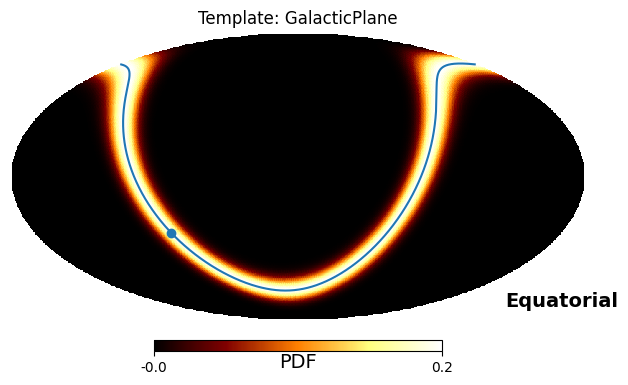

In [64]:
import healpy as hp

nside = 128
width_deg = 1
smearing_deg = 5
template_disc_gal = np.zeros(hp.nside2npix(nside))
pix_disc = hp.query_strip(nside=nside, theta1=np.pi/2.-np.deg2rad(width_deg), theta2=np.pi/2. + np.deg2rad(width_deg))
template_disc_gal[pix_disc] = 1.

# smear with Gaussian
template_disc_gal = hp.smoothing(template_disc_gal, sigma=np.deg2rad(smearing_deg))

# transform from galactic to equatorial coordinates
r = hp.Rotator(coord='GC')  # Transforms galactic to equatorial coordinates
theta_gal, phi_gal = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi
phi_gal = 1.754*np.pi - phi_gal # no clue why this makes it align....
theta_ecl, phi_ecl = r(theta_gal, phi_gal)  # Apply the conversion
print('phi_ecl', phi_ecl)
print(np.max(phi_ecl), np.min(phi_ecl))

template_disc = healpy.get_interp_val(template_disc_gal, theta_ecl, phi_ecl)

#skyplot = cy.plotting.SkyPlot(m=np.log10(template_disc), title='Template: GalacticPlane', unit=r'$\log_{10}(PDF)$')
skyplot = cy.plotting.SkyPlot(m=template_disc, title='Template: GalacticPlane', unit=r'PDF')
skyplot.show_gp()
skyplot.show_gc()
skyplot.fig.tight_layout()
skyplot.fig.savefig('{}/skymap_template_gp.png'.format(plot_dir))

#### GC template

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


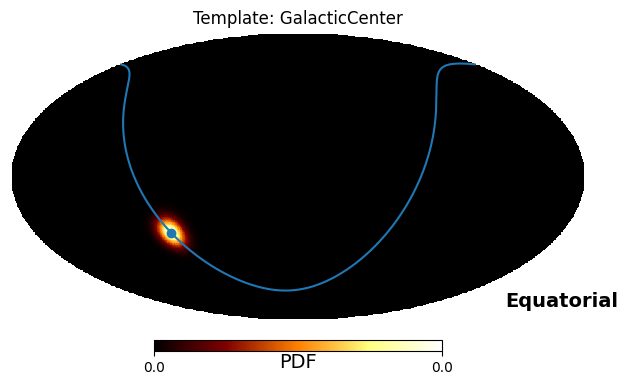

In [67]:
import healpy as hp

nside = 128
smearing_deg = 5

r = hp.Rotator(coord='GC')  # Transforms galactic to equatorial coordinates
theta, phi = r(np.pi/2., 0.)  # Apply the conversion
template_gc = np.zeros(hp.nside2npix(nside))
template_gc[hp.ang2pix(nside=nside, theta=theta, phi=phi)] = 1.

# smear with Gaussian
template_gc = hp.smoothing(template_gc, sigma=np.deg2rad(smearing_deg))
floor = 1e-7
template_gc[template_gc < floor] = floor

#skyplot = cy.plotting.SkyPlot(m=np.log10(template_gc), title='Template: GalacticCenter', unit=r'$\log_{10}(PDF)$')
skyplot = cy.plotting.SkyPlot(m=template_gc, title='Template: GalacticCenter', unit=r'PDF')
skyplot.show_gp()
skyplot.show_gc()
skyplot.fig.tight_layout()
skyplot.fig.savefig('{}/skymap_template_gc.png'.format(plot_dir))


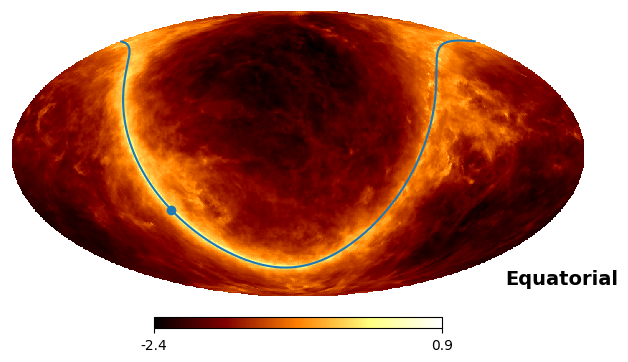

In [15]:
template_pi0 = cg.template_repo.get_template('Fermi-LAT_pi0_map')

skyplot = cy.plotting.SkyPlot(m=np.log10(template_pi0))
#skyplot = cy.plotting.SkyPlot(m=template_pi0)
skyplot.show_gp()
skyplot.show_gc()

## Setup Analysis

In [11]:
import sys
sys.path.insert(0, '../..')

import config as cg

cg.base_dir = '/data/user/mhuennefeld/data/analyses/baseline_analysis__v-1.0.0-rc1/'

Running as User: mhuennefeld on Hostname: cobalt05.icecube.wisc.edu


In [12]:
def get_gp_tr(template_str, cutoff=np.inf, gamma=None, cpus=20):
    cutoff_GeV = cutoff * 1e3
    gp_conf = cg.get_gp_conf(
        template_str=template_str, gamma=gamma, cutoff_GeV=cutoff_GeV, base_dir=cg.base_dir)
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr

def get_template_tr(template, gamma=2.7, cutoff_tev=np.inf, cpus=20):
    cutoff_gev = cutoff_tev * 1000.
    gp_conf = {
        'template': template,
        'flux': cy.hyp.PowerLawFlux(gamma, energy_cutoff=cutoff_gev),
        'randomize': ['ra'],
        'fitter_args': dict(gamma=gamma),
        'sigsub': True,
        'update_bg': True,
        'fast_weight': False,
    }
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr


#### Get trial runners

In [16]:
tr_dict = {
    'pi0': get_gp_tr('pi0'),
    'kra5': get_gp_tr('kra5'),
    'kra50': get_gp_tr('kra50'),
    'GalacticCenter': get_template_tr(template_gc),
    'GalacticPlane': get_template_tr(template_disc),
    'pi0_gamma2': get_template_tr(template_pi0, gamma=2.),
    'pi0_gamma3_10TeV': get_template_tr(template_pi0, gamma=3., cutoff_tev=10),
}

<- /data/user/mhuennefeld/data/analyses/baseline_analysis__v-1.0.0-rc1//templates/pi0/gamma/2.700/DNNCascade_10yr.template.npy    
Restore successful.
<- /data/user/mhuennefeld/data/analyses/baseline_analysis__v-1.0.0-rc1//templates/kra5/DNNCascade_10yr.template.npy    
Restore successful.
<- /data/user/mhuennefeld/data/analyses/baseline_analysis__v-1.0.0-rc1//templates/kra50/DNNCascade_10yr.template.npy    
Restore successful.
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr      

#### Get bkg fits for each template

In [17]:
bkg_file_dict = {
    'pi0': '{}/gp/trials/{}/{}/trials.dict'.format(cg.base_dir, 'DNNC', 'pi0'),
    'kra5': '{}/gp/trials/{}/{}/trials.dict'.format(cg.base_dir, 'DNNC', 'kra5'),
    'kra50': '{}/gp/trials/{}/{}/trials.dict'.format(cg.base_dir, 'DNNC', 'kra50'),
}
n_bkg_trials = 20000
seed = 1337

bkg_dict = {}
for key, tr in tr_dict.items():
    if key in bkg_file_dict:
        print('Loading background trials for template {}'.format(key))
        sig = np.load(bkg_file_dict[key], allow_pickle=True)
        bkg_dict[key] = cy.dists.TSD(sig['poisson']['nsig'][0.0]['ts'])
    
    else:
        print('Running background trials for template {}'.format(key))
        bkg_dict[key] = cy.dists.Chi2TSD(tr.get_many_fits(
            n_trials=n_bkg_trials, seed=seed, mp_cpus=20))
        

Loading background trials for template pi0
Loading background trials for template kra5
Loading background trials for template kra50
Running background trials for template GalacticCenter
Performing 20000 background trials using 20 cores:
      20000/20000 trials complete.   
Running background trials for template GalacticPlane
Performing 20000 background trials using 20 cores:
      20000/20000 trials complete.   
Running background trials for template pi0_gamma2
Performing 20000 background trials using 20 cores:
      20000/20000 trials complete.   
Running background trials for template pi0_gamma3_10TeV
Performing 20000 background trials using 20 cores:
      20000/20000 trials complete.   


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


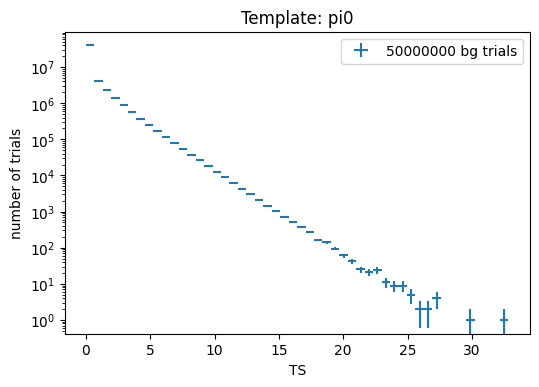

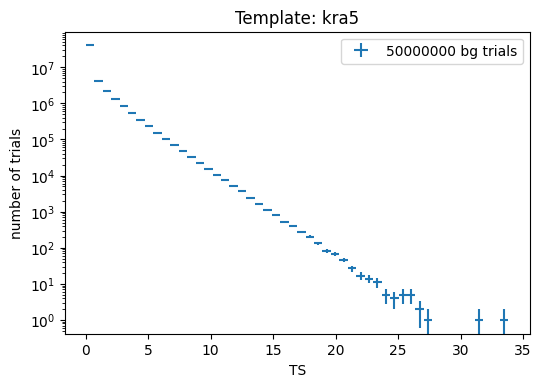

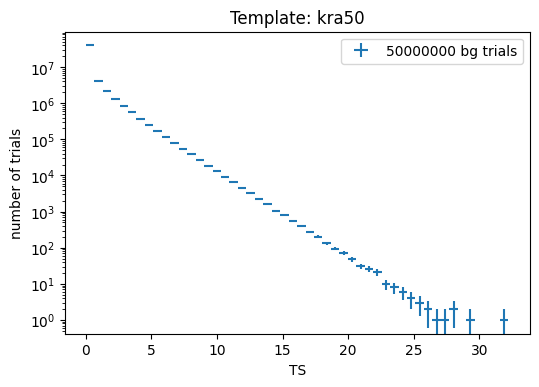

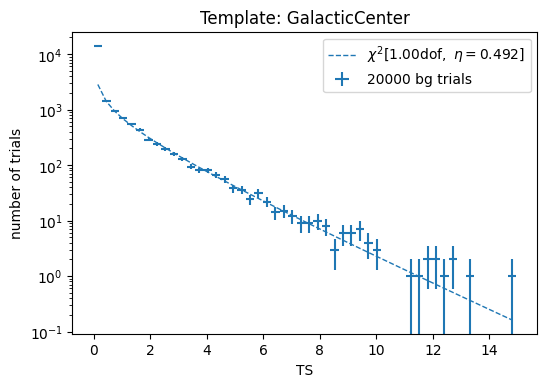

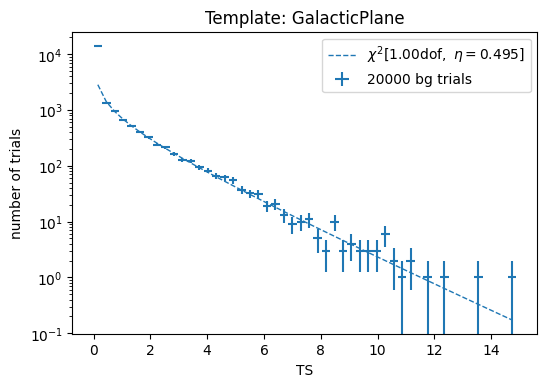

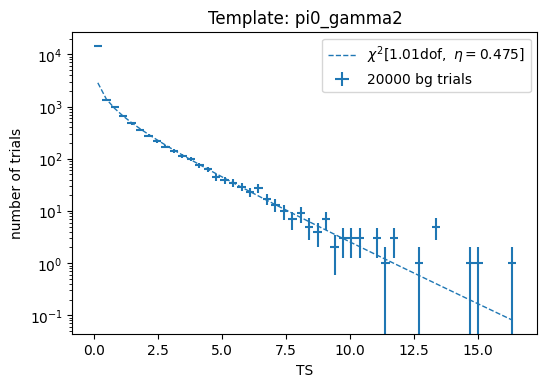

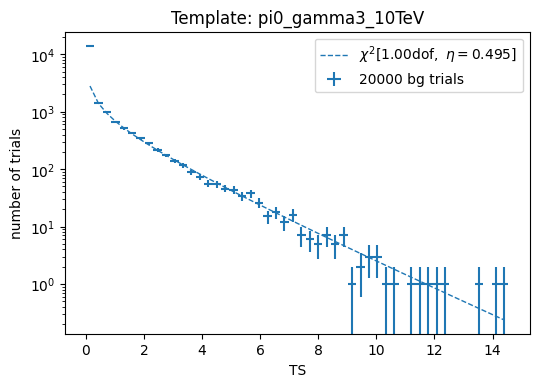

In [18]:
for key, bg in bkg_dict.items():
    fig, ax = plot_bkg_trials(bg)
    ax.set_title('Template: {}'.format(key))
    ax.set_yscale('log')
    

#### Define n-sigma ns for each template

In [33]:
nsigma = 5

if nsigma == 5:
    ns_dict = {
        'pi0': 752, #540,
        'kra5': 281, #230,
        'kra50': 233, #278,
    }
    
elif nsigma == 4:
    ns_dict = {
        'pi0': 590,
        'kra5': 222,
        'kra50': 184,
    }
    
elif nsigma == 3:
    ns_dict = {
        'pi0': 433,
        'kra5': 161,
        'kra50': 133,
    }
else:
    raise ValueError(nsigma)

print('Using nsigma = ', nsigma)

Using nsigma =  5


#### Compute nsigma for new templates

In [41]:
for key, tr in tr_dict.items():
    if key not in ns_dict:
        print('Computing ns for {} sigma for template {}'.format(nsigma, key))
        
        template_sens = tr.find_n_sig(
            bkg_dict[key].isf_nsigma(nsigma),
            0.5, #percent above threshold (0.5 for dp)
            n_sig_step=50,
            batch_size = 1000, 
            tol = 0.02,
        )
        ns_dict[key] = template_sens['n_sig']
        

Computing ns for 5 sigma for template GalacticCenter
Start time: 2022-01-19 07:33:36.712055
Using 20 cores.
* Starting initial scan for 50% of 50 trials with TS >= 24.476...
  n_sig = 50.000 ... frac = 0.02000
  n_sig = 100.000 ... frac = 0.18000
  n_sig = 150.000 ... frac = 0.60000
* Generating batches of 1000 trials...
n_trials | n_inj    0.00   60.00  120.00  180.00  240.00  300.00  |  n_sig(relative error)
1000     |          0.0%    0.7%   24.7%   87.2%   99.3%  100.0%  |    142.028 (+/-  1.4%) [chi2.cdf]
End time: 2022-01-19 07:35:15.957615
Elapsed time: 0:01:39.245560
Computing ns for 5 sigma for template GalacticPlane
Start time: 2022-01-19 07:35:15.963169
Using 20 cores.
* Starting initial scan for 50% of 50 trials with TS >= 24.584...
  n_sig = 50.000 ... frac = 0.00000
  n_sig = 100.000 ... frac = 0.00000
  n_sig = 150.000 ... frac = 0.00000
  n_sig = 200.000 ... frac = 0.00000
  n_sig = 250.000 ... frac = 0.00000
  n_sig = 300.000 ... frac = 0.00000
  n_sig = 350.000 ... fr

In [44]:
ns_dict

{'pi0': 752,
 'kra5': 281,
 'kra50': 233,
 'pi0_gamma2': 186.18118813435595,
 'pi0_gamma3_10TeV': 1163.1619820703,
 'GalacticCenter': 142.028159127423,
 'GalacticPlane': 600.0}

#### Get trials for each template

In [45]:
from tqdm.notebook import tqdm_notebook as tqdm

n_trials = 100
seed = 42
trials_dict = {}

for key, tr in tr_dict.items():
    
    n_sig = ns_dict[key]
    trials = []
    
    print('Injecting {} signal events for template {}'.format(n_sig, key))
    for i in tqdm(range(n_trials), total=n_trials):
        trials.append(tr.get_one_trial(n_sig=n_sig, poisson=True, seed=seed + i))
    
    trials_dict[key] = trials
    

Injecting 752 signal events for template pi0


  0%|          | 0/100 [00:00<?, ?it/s]

Injecting 281 signal events for template kra5


  0%|          | 0/100 [00:00<?, ?it/s]

Injecting 233 signal events for template kra50


  0%|          | 0/100 [00:00<?, ?it/s]

Injecting 142.028159127423 signal events for template GalacticCenter


  0%|          | 0/100 [00:00<?, ?it/s]

Injecting 600.0 signal events for template GalacticPlane


  0%|          | 0/100 [00:00<?, ?it/s]

Injecting 186.18118813435595 signal events for template pi0_gamma2


  0%|          | 0/100 [00:00<?, ?it/s]

Injecting 1163.1619820703 signal events for template pi0_gamma3_10TeV


  0%|          | 0/100 [00:00<?, ?it/s]

#### Get fits for each template combination

In [46]:
ts_dict = {}
for key_inj, tr_inj in tr_dict.items():
    
    for key, tr in tr_dict.items():
        print('Computing TS values for injection {} and testing with {}'.format(key_inj, key))

        ts_values = []
        n_values = len(trials_dict[key_inj])
        for trial in tqdm(trials_dict[key_inj], total=n_values):
            ts_values.append(tr.get_one_fit_from_trial(trial)) 
        
        ts_values = np.array(ts_values)
        ts_dict[(key_inj, key)] = cy.utils.Arrays({
          'ts': ts_values[:, 0],  
          'ns': ts_values[:, 1],  
        })




Computing TS values for injection pi0 and testing with pi0


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0 and testing with kra5


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0 and testing with kra50


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0 and testing with GalacticCenter


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0 and testing with GalacticPlane


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0 and testing with pi0_gamma2


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0 and testing with pi0_gamma3_10TeV


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra5 and testing with pi0


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra5 and testing with kra5


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra5 and testing with kra50


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra5 and testing with GalacticCenter


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra5 and testing with GalacticPlane


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra5 and testing with pi0_gamma2


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra5 and testing with pi0_gamma3_10TeV


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra50 and testing with pi0


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra50 and testing with kra5


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra50 and testing with kra50


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra50 and testing with GalacticCenter


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra50 and testing with GalacticPlane


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra50 and testing with pi0_gamma2


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection kra50 and testing with pi0_gamma3_10TeV


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticCenter and testing with pi0


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticCenter and testing with kra5


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticCenter and testing with kra50


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticCenter and testing with GalacticCenter


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticCenter and testing with GalacticPlane


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticCenter and testing with pi0_gamma2


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticCenter and testing with pi0_gamma3_10TeV


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticPlane and testing with pi0


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticPlane and testing with kra5


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticPlane and testing with kra50


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticPlane and testing with GalacticCenter


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticPlane and testing with GalacticPlane


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticPlane and testing with pi0_gamma2


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection GalacticPlane and testing with pi0_gamma3_10TeV


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma2 and testing with pi0


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma2 and testing with kra5


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma2 and testing with kra50


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma2 and testing with GalacticCenter


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma2 and testing with GalacticPlane


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma2 and testing with pi0_gamma2


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma2 and testing with pi0_gamma3_10TeV


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma3_10TeV and testing with pi0


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma3_10TeV and testing with kra5


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma3_10TeV and testing with kra50


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma3_10TeV and testing with GalacticCenter


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma3_10TeV and testing with GalacticPlane


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma3_10TeV and testing with pi0_gamma2


  0%|          | 0/100 [00:00<?, ?it/s]

Computing TS values for injection pi0_gamma3_10TeV and testing with pi0_gamma3_10TeV


  0%|          | 0/100 [00:00<?, ?it/s]

#### Compute significance

In [47]:
p_val_dict = {}
sigma_dict = {}
for key, ts_values in ts_dict.items():
    bg = bkg_dict[key[1]]
    max_bg_ts = np.max(bg.values)
    mask_above = ts_values.ts > max_bg_ts
    ts = np.array(ts_values.ts)
    if np.sum(mask_above) > 0:
        print('Setting {} ts values to max bkg ts value of {}.'.format(
            np.sum(mask_above), max_bg_ts))
        ts[mask_above] = max_bg_ts
    p_val_dict[key] = bg.sf(ts)
    sigma_dict[key] = bg.sf_nsigma(ts)


Setting 29 ts values to max bkg ts value of 32.8364078105636.
Setting 9 ts values to max bkg ts value of 33.83666624471796.
Setting 7 ts values to max bkg ts value of 32.23180222945865.
Setting 9 ts values to max bkg ts value of 14.956188809737565.
Setting 74 ts values to max bkg ts value of 14.887916407764854.
Setting 12 ts values to max bkg ts value of 16.503140228742208.
Setting 86 ts values to max bkg ts value of 14.55006578066509.
Setting 4 ts values to max bkg ts value of 32.8364078105636.
Setting 16 ts values to max bkg ts value of 33.83666624471796.
Setting 17 ts values to max bkg ts value of 32.23180222945865.
Setting 49 ts values to max bkg ts value of 14.956188809737565.
Setting 16 ts values to max bkg ts value of 14.887916407764854.
Setting 5 ts values to max bkg ts value of 16.503140228742208.
Setting 43 ts values to max bkg ts value of 14.55006578066509.
Setting 3 ts values to max bkg ts value of 32.8364078105636.
Setting 17 ts values to max bkg ts value of 33.83666624471

#### Plot Distributions

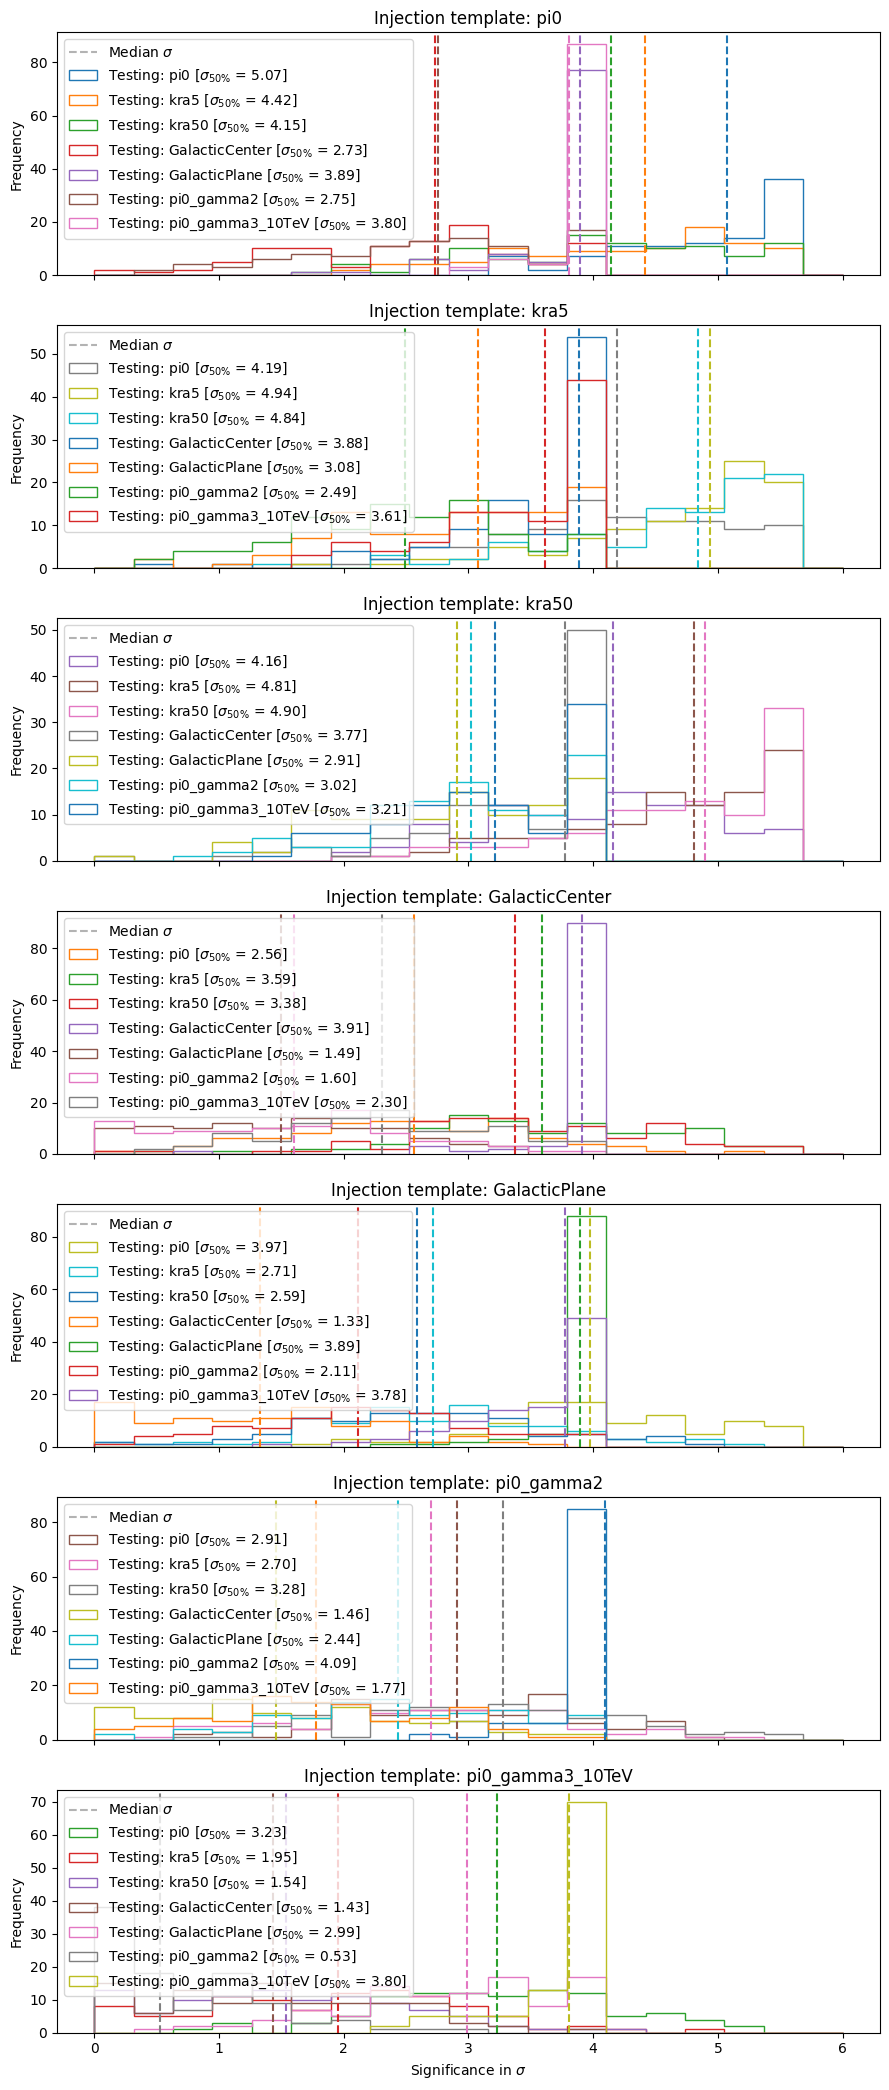

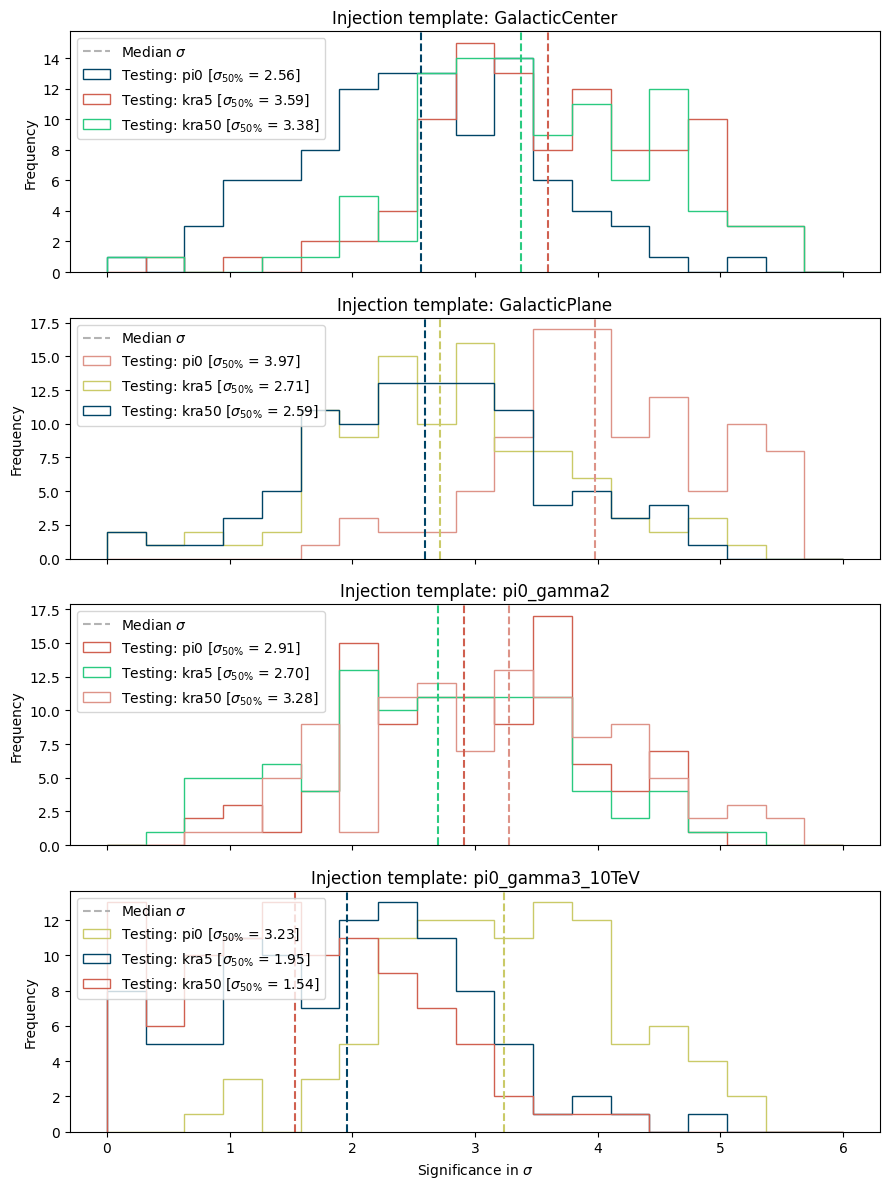

In [68]:
from itertools import cycle

def plot_model_confusion(template_keys, testing_keys=None, bins=np.linspace(0, 6, 20)):
    n_keys = len(template_keys)
    
    if testing_keys is None:
        testing_keys = template_keys
        
    fig, axes = plt.subplots(n_keys, 1, figsize=(9, 3*n_keys), sharex=True)
    
    if n_keys <= 5:
        color_cycle = cycle(soft_colors)
    else:
        color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    for i, key_inj in enumerate(template_keys):

        ax = axes[i]
        ax.set_title('Injection template: {}'.format(key_inj))

        for j, key in enumerate(testing_keys):
            sigmas = sigma_dict[(key_inj, key)]
            if not np.isfinite(sigmas).all():
                raise ValueError(sigmas)
            color = next(color_cycle)
            ax.hist(
                sigmas, bins=bins, 
                histtype='step',
                color=color,
                label=r'Testing: {}'.format(key) + ' [$\sigma_{50\%}$ = ' + '{:3.2f}]'.format(np.median(sigmas)),
            )
            ax.axvline(np.median(sigmas), color=color, ls='--')

        ax.plot(np.inf, np.inf, color='0.7', ls='--', label='Median $\sigma$')
        ax.legend(loc='upper left')
        ax.set_ylabel('Frequency')

    axes[-1].set_xlabel('Significance in $\sigma$')

    fig.tight_layout()
    return fig

if False:
    fig = plot_model_confusion(template_keys=['pi0', 'kra5', 'kra50'])
    fig.savefig('{}/model_confusion_nsigma_{:3.2f}.png'.format(plot_dir, nsigma))

fig = plot_model_confusion(template_keys=list(tr_dict.keys()))
fig.savefig('{}/model_confusion_nsigma_{:3.2f}_all.png'.format(plot_dir, nsigma))

fig = plot_model_confusion(
    template_keys=['GalacticCenter', 'GalacticPlane', 'pi0_gamma2', 'pi0_gamma3_10TeV'], 
    testing_keys=['pi0', 'kra5', 'kra50'],
)
fig.savefig('{}/model_confusion_nsigma_{:3.2f}_sys.png'.format(plot_dir, nsigma))



#### Scatter Plot between KRA-gamma 5 PeV and Pi0

In [ ]:

for m1, m2 in [['pi0', 'kra5'], ['pi0', 'kra50'], ['kra5', 'kra50']]:
    
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    bins = (np.linspace(1., 6., 15), np.linspace(1., 6., 15))

    # injection of pi0
    axes[0].hist2d(sigma_dict[(m1, m1)], sigma_dict[(m1, m2)], bins=bins, cmin=1)
    axes[0].set_title('Injection template: {}'.format(m1))

    axes[1].hist2d(sigma_dict[(m2, m1)], sigma_dict[(m2, m2)], bins=bins, cmin=1)
    axes[1].set_title('Injection template: {}'.format(m2))

    axes[0].set_ylabel('$n\cdot \sigma$ tested with {}'.format(m2))
    axes[1].set_ylabel('$n\cdot \sigma$ tested with {}'.format(m2))
    axes[-1].set_xlabel('$n\cdot \sigma$ tested with {}'.format(m1))

    for ax in axes:
        ax.plot((bins[0][0], bins[0][-1]), (bins[0][0], bins[0][-1]), ls='--', color='0.8', lw=2)

    fig.tight_layout()
    fig.savefig('{}/model_confusion_correlation_{}_{}_nsigma_{:3.2f}.png'.format(plot_dir, m1, m2, nsigma))
    
    